In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as D

from torchsummary import summary

plt.style.use("fivethirtyeight")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
log_steps = 100

In [3]:
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")
original_csv = pd.read_csv("original.csv")

In [4]:
print(train_csv.shape)
print(test_csv.shape)

(42000, 785)
(28000, 784)


In [5]:
def normalize(x: np.ndarray) -> np.ndarray:
    assert x.min() >= 0 and x.max() <= 255
    return x.astype(np.float32) / 255.0


def denormalize(x: np.ndarray) -> np.ndarray:
    return (x * 255.0).astype(np.int32).clip(0, 255)


def split(x: np.ndarray, y: np.ndarray, first_percentage: float = 0.5) -> np.ndarray:
    index = int(first_percentage * x.shape[0])
    return x[:index], x[index:], y[:index], y[index:]

In [10]:
train_x = train_csv.iloc[:, 1:].to_numpy()
train_y = train_csv.iloc[:, 0].to_numpy()
test_x = test_csv.to_numpy()

train_x = normalize(train_x)
test_x = normalize(test_x)

train_x, validation_x, train_y, validation_y = split(
    train_x, train_y, first_percentage=0.8
)

In [11]:
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
validation_x = torch.from_numpy(validation_x).type(torch.FloatTensor)
train_y = torch.from_numpy(train_y).type(torch.LongTensor)
validation_y = torch.from_numpy(validation_y).type(torch.LongTensor)
test_x = torch.from_numpy(test_x)

In [12]:
print(train_x.shape)
print(validation_x.shape)
print(test_x.shape)

torch.Size([33600, 784])
torch.Size([8400, 784])
torch.Size([28000, 784])


In [13]:
trainloader = D.DataLoader(
    D.TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True
)
validationloader = D.DataLoader(
    D.TensorDataset(validation_x, validation_y), batch_size=batch_size, shuffle=True
)
testloader = D.DataLoader(test_x, batch_size=batch_size, shuffle=False)

In [14]:
@torch.no_grad()
def evaluate(model, loss_fn):
    aggregate_loss = 0
    correct = 0
    num_batches = 0

    model.eval()
    for x, y in validationloader:
        num_batches += 1
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = loss_fn(output, y)

        aggregate_loss += loss.mean()
        prediction = output.data.max(axis=1).indices
        correct += prediction.eq(y).cpu().numpy().sum()

    aggregate_loss /= num_batches
    accuracy = 100 * correct / len(validationloader.dataset)

    return aggregate_loss, accuracy


@torch.no_grad()
def predict(model):
    predictions = torch.LongTensor().to(device)

    model.eval()
    for x in testloader:
        x = x.to(device)
        output = model(x)
        prediction = output.data.max(axis=1).indices
        predictions = torch.cat([predictions, prediction], dim=0)

    return predictions


def train(model, loss_fn, optimizer, scheduler, epochs: int):
    steps = 0
    loss_history = []

    model.train()
    for epoch in range(epochs):
        aggregate_loss = 0
        correct = 0
        num_batches = 0

        for x, y in trainloader:
            num_batches += 1
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            prediction = output.data.max(1).indices
            correct += prediction.eq(y).cpu().numpy().sum()

            if steps % log_steps == 0:
                print(f"Epoch: {epoch}, Training Loss: {loss.item():.5f}")

            loss_history.append(loss.item())
            aggregate_loss += loss.mean()
            steps += 1

        aggregate_loss /= num_batches
        training_accuracy = 100 * correct / len(trainloader.dataset)
        validation_loss, validation_accuracy = evaluate(model, loss_fn)

        print("-" * 80)
        print(f"               Epoch: {epoch}")
        print(f"  Avg. Training loss: {aggregate_loss:.5f}")
        print(f"Avg. Validation loss: {validation_loss:.5f}")
        print(f"   Training accuracy: {training_accuracy:.3f}")
        print(f" Validation accuracy: {validation_accuracy:.3f}")
        print("-" * 80)

        scheduler.step()

    return loss_history

In [15]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=256, out_features=10),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        x = x.view(-1, 784).to(device)
        return self.model(x)

In [16]:
learning_rate = 1e-3
weight_decay = 1e-3

model = SimpleModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=8, gamma=0.1)

In [17]:
_ = summary(model=model, input_data=(784,), dtypes=[torch.FloatTensor], device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 256]                 200,960
|    └─ReLU: 2-2                         [-1, 256]                 --
|    └─Dropout: 2-3                      [-1, 256]                 --
|    └─Linear: 2-4                       [-1, 256]                 65,792
|    └─ReLU: 2-5                         [-1, 256]                 --
|    └─Dropout: 2-6                      [-1, 256]                 --
|    └─Linear: 2-7                       [-1, 10]                  2,570
|    └─ReLU: 2-8                         [-1, 10]                  --
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
Total mult-adds (M): 0.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.03
Estimated Total Size (MB): 1.03


In [50]:
loss_history = train(model, loss_fn, optimizer, scheduler, epochs=10)

Epoch: 0, Training Loss: 2.30618
Epoch: 0, Training Loss: 0.46165
Epoch: 0, Training Loss: 0.39497
Epoch: 0, Training Loss: 0.29574
Epoch: 0, Training Loss: 0.23212
Epoch: 0, Training Loss: 0.19060
--------------------------------------------------------------------------------
               Epoch: 0
  Avg. Training loss: 0.45898
Avg. Validation loss: 0.14935
   Training accuracy: 86.115
 Validation accuracy: 95.660
--------------------------------------------------------------------------------
Epoch: 1, Training Loss: 0.07149
Epoch: 1, Training Loss: 0.15906
Epoch: 1, Training Loss: 0.13411
Epoch: 1, Training Loss: 0.08032
Epoch: 1, Training Loss: 0.17844
--------------------------------------------------------------------------------
               Epoch: 1
  Avg. Training loss: 0.11520
Avg. Validation loss: 0.08263
   Training accuracy: 96.463
 Validation accuracy: 97.531
--------------------------------------------------------------------------------
Epoch: 2, Training Loss: 0.12

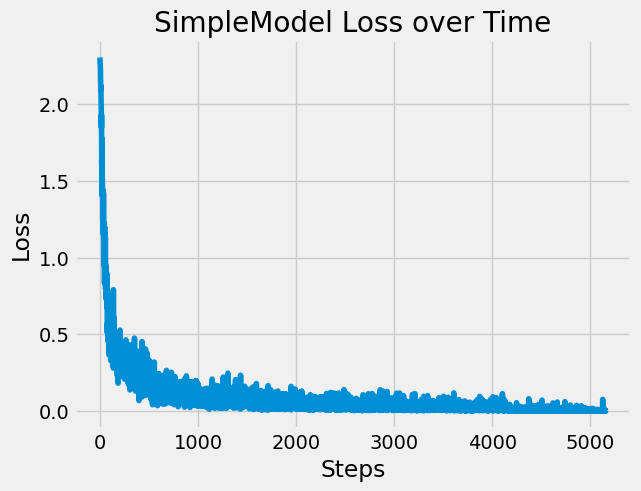

In [51]:
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title(f"{model.__class__.__name__} Loss over Time")
plt.show()

In [52]:
predictions = predict(model)
submission_df = pd.read_csv("sample_submission.csv")
submission_df["Label"] = predictions.cpu().numpy()
submission_df.to_csv(f"{model.__class__.__name__}_submission.csv", index=False)

In [53]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=0
            ),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(in_features=128 * 4 * 4, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(in_features=64, out_features=10),
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        x = x.view(-1, 1, 28, 28).to(device)
        return self.model(x)

In [54]:
learning_rate = 1e-3
weight_decay = 1e-3

model = CNNModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=8, gamma=0.1)

In [55]:
_ = summary(
    model=model, input_data=(1, 28, 28), dtypes=[torch.FloatTensor], device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          544
|    └─BatchNorm2d: 2-2                  [-1, 32, 14, 14]          64
|    └─ReLU: 2-3                         [-1, 32, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 64, 7, 7]            32,832
|    └─BatchNorm2d: 2-5                  [-1, 64, 7, 7]            128
|    └─ReLU: 2-6                         [-1, 64, 7, 7]            --
|    └─Conv2d: 2-7                       [-1, 128, 4, 4]           131,200
|    └─BatchNorm2d: 2-8                  [-1, 128, 4, 4]           256
|    └─ReLU: 2-9                         [-1, 128, 4, 4]           --
|    └─Flatten: 2-10                     [-1, 2048]                --
|    └─Dropout: 2-11                     [-1, 2048]                --
|    └─Linear: 2-12                      [-1, 256]                 524,54

In [56]:
loss_history = train(model, loss_fn, optimizer, scheduler, epochs=10)

Epoch: 0, Training Loss: 2.30977
Epoch: 0, Training Loss: 0.13432
Epoch: 0, Training Loss: 0.18948
Epoch: 0, Training Loss: 0.12265
Epoch: 0, Training Loss: 0.10436
Epoch: 0, Training Loss: 0.07535
--------------------------------------------------------------------------------
               Epoch: 0
  Avg. Training loss: 0.21556
Avg. Validation loss: 0.05009
   Training accuracy: 93.558
 Validation accuracy: 98.546
--------------------------------------------------------------------------------
Epoch: 1, Training Loss: 0.02628
Epoch: 1, Training Loss: 0.05857
Epoch: 1, Training Loss: 0.01797
Epoch: 1, Training Loss: 0.01822
Epoch: 1, Training Loss: 0.06268
--------------------------------------------------------------------------------
               Epoch: 1
  Avg. Training loss: 0.04509
Avg. Validation loss: 0.03001
   Training accuracy: 98.676
 Validation accuracy: 99.174
--------------------------------------------------------------------------------
Epoch: 2, Training Loss: 0.02

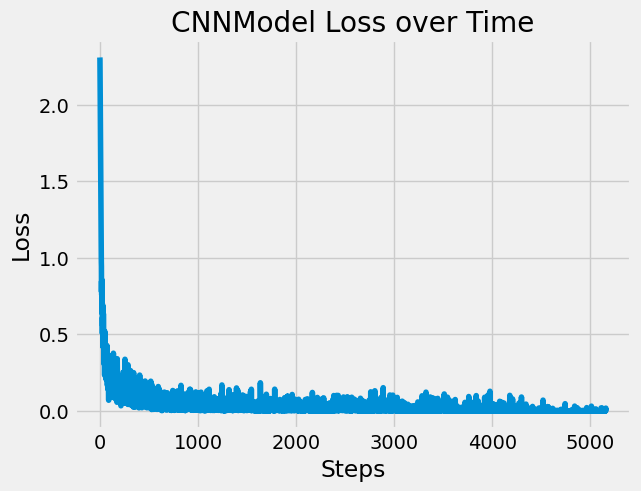

In [57]:
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title(f"{model.__class__.__name__} Loss over Time")
plt.show()

In [58]:
predictions = predict(model)
submission_df = pd.read_csv("sample_submission.csv")
submission_df["Label"] = predictions.cpu().numpy()
submission_df.to_csv(f"{model.__class__.__name__}_submission.csv", index=False)

In [150]:
class ConditionalDCGAN(nn.Module):
    def __init__(self, latent_channels: int, num_embeddings: int):
        super().__init__()

        self.latent_channels = latent_channels
        self.num_embeddings = num_embeddings

        self.embedding_pass_g = self.generator_block(num_embeddings, 128, 4, 2, 1)
        self.latent_pass = self.generator_block(latent_channels, 128, 4, 2, 1)

        self.embedding_pass_d = self.discriminator_block(num_embeddings, 16, 4, 2, 1)
        self.image_pass = self.discriminator_block(1, 16, 4, 2, 1)

        self.generator = nn.Sequential(
            self.generator_block(256, 128, 4, 2, 1),
            self.generator_block(128, 64, 4, 1, 0),
            self.generator_block(64, 32, 4, 2, 1),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.ReLU(),
        )

        self.discriminator = nn.Sequential(
            self.discriminator_block(32, 64, 4, 2, 1),
            self.discriminator_block(64, 128, 4, 1, 0),
            self.discriminator_block(128, 160, 4, 2, 1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(in_features=160 * 2 * 2, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid(),
        )

    def generator_block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        strides: int,
        padding: int,
    ) -> nn.Sequential:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, strides, padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def discriminator_block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        strides: int,
        padding: int,
    ) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward_generator(
        self, x: torch.FloatTensor, l: torch.FloatTensor
    ) -> torch.FloatTensor:
        x = x.view(-1, self.latent_channels, 1, 1).to(device)
        l = l.view(-1, self.num_embeddings, 1, 1).to(device)

        x = self.latent_pass(x)
        l = self.embedding_pass_g(l)

        x = torch.cat([x, l], dim=1)
        return self.generator(x)

    def forward_discriminator(
        self, x: torch.FloatTensor, l: torch.FloatTensor
    ) -> torch.FloatTensor:
        x = x.view(-1, 1, 28, 28).to(device)
        l = l.view(-1, self.num_embeddings, 28, 28).to(device)

        x = self.image_pass(x)
        l = self.embedding_pass_d(l)

        x = torch.cat([x, l], dim=1)
        return self.discriminator(x).squeeze()

    def forward(
        self,
        x1: torch.FloatTensor,
        x2: torch.FloatTensor,
        l1: torch.FloatTensor,
        l2: torch.FloatTensor,
    ) -> torch.FloatTensor:
        # This method is not used for training. It is only used to obtain model summary

        x1 = x1.view(-1, self.latent_channels, 1, 1).to(device)
        x2 = x2.view(-1, 1, 28, 28).to(device)
        l1 = l1.view(-1, self.num_embeddings, 1, 1).to(device)
        l2 = l2.view(-1, self.num_embeddings, 28, 28).to(device)

        e1 = self.embedding_pass_g(l1)
        e2 = self.embedding_pass_d(l2)
        x1 = self.latent_pass(x1)
        x2 = self.image_pass(x2)

        x1 = torch.cat([x1, e1], dim=1)
        x2 = torch.cat([x2, e2], dim=1)

        return self.generator(x1), self.discriminator(x2)

In [151]:
learning_rate_g = 1e-4
learning_rate_d = 2e-4
steps_g = 2
steps_d = 3
latent_channels = 64
num_embeddings = 10

model = ConditionalDCGAN(latent_channels=latent_channels, num_embeddings=num_embeddings)
loss_fn = nn.BCELoss()
optimizer_g = optim.AdamW(model.generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.AdamW(model.discriminator.parameters(), lr=learning_rate_d)
scheduler_g = optim.lr_scheduler.StepLR(optimizer=optimizer_g, step_size=8, gamma=0.1)
scheduler_d = optim.lr_scheduler.StepLR(optimizer=optimizer_d, step_size=8, gamma=0.1)

In [152]:
onehot = F.one_hot(torch.arange(num_embeddings)).type(torch.FloatTensor)
embeddings = torch.zeros([num_embeddings, num_embeddings, 28, 28]).type(
    torch.FloatTensor
)
for i in range(num_embeddings):
    embeddings[i, i, :, :] = 1

In [153]:
_ = summary(
    model=model,
    input_data=[
        (latent_channels,),
        (1, 28, 28),
        (num_embeddings,),
        (num_embeddings, 28, 28),
    ],
    dtypes=[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 2, 2]           --
|    └─ConvTranspose2d: 2-1              [-1, 128, 2, 2]           20,608
|    └─BatchNorm2d: 2-2                  [-1, 128, 2, 2]           256
|    └─ReLU: 2-3                         [-1, 128, 2, 2]           --
├─Sequential: 1-2                        [-1, 16, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 16, 14, 14]          2,576
|    └─BatchNorm2d: 2-5                  [-1, 16, 14, 14]          32
|    └─ReLU: 2-6                         [-1, 16, 14, 14]          --
├─Sequential: 1-3                        [-1, 128, 2, 2]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 2, 2]           131,200
|    └─BatchNorm2d: 2-8                  [-1, 128, 2, 2]           256
|    └─ReLU: 2-9                         [-1, 128, 2, 2]           --
├─Sequential: 1-4                        [-1, 16, 14, 14]          --
|

In [154]:
def trainstep_g() -> torch.FloatTensor:
    optimizer_g.zero_grad()

    latent = torch.randn((batch_size, latent_channels))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = model.forward_generator(latent, onehot[fake_labels])
    fake_validity = model.forward_discriminator(fake_images, embeddings[fake_labels])
    fake_loss = loss_fn(fake_validity, torch.ones(batch_size, device=device))

    fake_loss.backward()
    optimizer_g.step()
    return fake_loss


def trainstep_d(
    images: torch.FloatTensor, labels: torch.LongTensor
) -> torch.FloatTensor:
    optimizer_d.zero_grad()

    batch_size = images.shape[0]
    real_validity = model.forward_discriminator(images, embeddings[labels])
    real_loss = loss_fn(real_validity, torch.ones(batch_size, device=device))

    latent = torch.randn((batch_size, latent_channels))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = model.forward_generator(latent, onehot[fake_labels])
    fake_validity = model.forward_discriminator(images, embeddings[fake_labels])
    fake_loss = loss_fn(fake_validity, torch.zeros(batch_size, device=device))

    discriminator_loss = (real_loss + fake_loss) / 2
    discriminator_loss.backward()
    optimizer_d.step()
    return discriminator_loss


def train_cdcgan(epochs: int):
    steps = 0
    correct = 0
    generator_loss_history = []
    discriminator_loss_history = []

    model.train()
    for epoch in range(epochs):
        aggregate_loss = 0

        for x, y in trainloader:
            generator_loss = 0
            discriminator_loss = 0

            for _ in range(steps_d):
                discriminator_loss += trainstep_d(x, y).mean()
            for _ in range(steps_g):
                generator_loss += trainstep_g().mean()

            discriminator_loss_history.append(discriminator_loss / steps_d)
            generator_loss_history.append(generator_loss / steps_g)

            real_validity = model.forward_discriminator(x, embeddings[y])
            real_loss = loss_fn(real_validity, torch.ones(y.shape[0], device=device))
            aggregate_loss += real_loss

            if steps % log_steps == 0:
                print(
                    f"Epoch: {epoch}, Generator Loss: {generator_loss:.5f}, Discriminator Loss: {discriminator_loss:.5f}"
                )
            steps += 1

        aggregate_loss /= num_batches
        training_accuracy = 100 * correct / len(trainloader.dataset)
        validation_loss, validation_accuracy = evaluate(model, loss_fn)

        print("-" * 80)
        print(f"               Epoch: {epoch}")
        print(f"  Avg. Training loss: {aggregate_loss:.5f}")
        print(f"Avg. Validation loss: {validation_loss:.5f}")
        print(f"   Training accuracy: {training_accuracy:.3f}")
        print(f" Validation accuracy: {validation_accuracy:.3f}")
        print("-" * 80)

        scheduler_g.step()
        scheduler_d.step()

    return generator_loss_history, discriminator_loss_history

In [ ]:
generator_loss_history, discriminator_loss_history = train_cdcgan(epochs=1)